# Lab 2 - Regression and Hypothesis Testing
- **Author:** Qutub Khan Vajihi ([qutubkhan.vajihi@berkeley.edu](mailto:dimitri@berkeley.edu)) (based on Dimitris Papadimitriou's Lab)
- **Date:** 3 February 2021
- **Course:** INFO 251: Applied machine learning

### Learning Objectives:
By the end of the lab, you will be able to:

* Design formulas for linear regression modeling
* Work efficiently with the *statsmodels* library 
* Interpret coefficients for regression models

### Topics:
1. T-tests
2. Univariate regression
3. Multivariate regressions
4. Dummy variables
5. Interactions

### References: 
 * [Statsmodels](http://www.statsmodels.org/stable/example_formulas.html#loading-modules-and-functions) 
 * [Applied regression analysis](http://www.stat.washington.edu/elena/classes/syllabus504-2015.htm)

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.datasets import load_boston
%matplotlib inline  


# The packages you'll need for t-test and regression models. 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import scipy as sp

### 1. T-test 

A t-test is a type of inferential statistic used to determine if there is a significant difference between the means of two groups, which may be related in certain features. Let's look at an example - 

In [3]:
# Import Boston Housing data
bdata = load_boston()

In [4]:
boston = pd.DataFrame(bdata.data)
boston.columns = bdata.feature_names[:]
boston['MEDV'] = bdata.target

In [5]:
boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Let's split the NOX column in two using the 50% mark and do an independent t-test. Note - nitric oxides concentration is in parts per 10 million

In [33]:
stats.ttest_ind(boston[boston.CHAS < 0.538].MEDV, boston[boston.CHAS >= 0.538].MEDV, axis = 0, equal_var = True)

Ttest_indResult(statistic=-3.996437466090509, pvalue=7.390623170519905e-05)

Let's double check the variance!

In [34]:
np.var(boston[boston.CHAS < 0.538].MEDV), np.var(boston[boston.CHAS >= 0.538].MEDV)

(77.82737185641962, 135.64354285714285)

In [35]:
stats.ttest_ind(boston[boston.CHAS < 0.538].MEDV, boston[boston.CHAS >= 0.538].MEDV, axis = 0, equal_var = False)

Ttest_indResult(statistic=-3.113291312794837, pvalue=0.003567170098137517)

The equal_var=False parameter means the Welch's t-test is used, assuming unequal variance.

There is another very useful parameter in the ttest_ind function - *nan_policy*. Use this if the vectors you're inputting contain NULL values.

In [36]:
stats.ttest_ind(boston[boston.CHAS < 0.538].MEDV, boston[boston.CHAS >= 0.538].MEDV, axis = 0, equal_var = False, nan_policy='omit')

Ttest_indResult(statistic=-3.113291312794837, pvalue=0.003567170098137517)

### 2. Regression

Linear regression provides us a concise summary of the mean of one variable as a function of another variables(s) through two types of parameters - the slope and the intercept

#### 2.1 Interpretation of slope

Here we have some synthetic data about House damage (thousands of dollars) and distance from the fire station (miles) of 15 house fires. The data is collected for a given area.

In [37]:
distance = [3.4, 2.6, 1.8, 4.3, 4.6, 2.1, 2.3, 1.1, 3.1, 6.1, 5.5, 4.8, 0.7, 3.8, 3.0]
damage = [26.2, 19.6, 17.8, 31.3, 31.3, 24.0, 23.1, 17.3, 27.5, 43.2, 36.0, 36.4, 14.1, 26.1, 22.3]
fire_df = pd.DataFrame({'distance':distance, 'damage':damage})
fire_df

,distance,damage
0,3.4,26.2
1,2.6,19.6
2,1.8,17.8
3,4.3,31.3
4,4.6,31.3
5,2.1,24.0
6,2.3,23.1
7,1.1,17.3
8,3.1,27.5
9,6.1,43.2


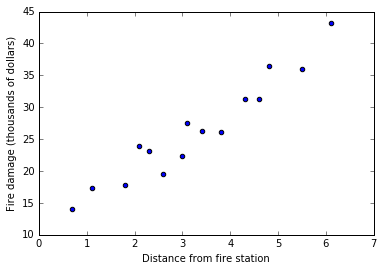

In [8]:
plt.scatter(fire_df.distance, fire_df.damage)
plt.xlabel('Distance from fire station')
plt.ylabel('Fire damage (thousands of dollars)')

In [40]:
# Let's look at the correlation coef.
np.corrcoef(fire_df.distance, fire_df.damage)[0,1]

0.9609777151321091

Text(0, 0.5, 'Fire damage (thousands of dollars)')

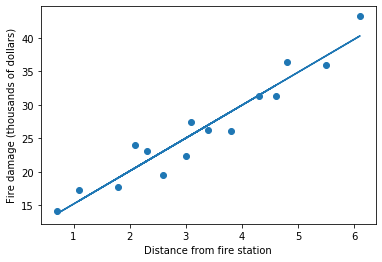

In [66]:
plt.scatter(fire_df.distance, fire_df.damage)
x, y =fire_df.distance, fire_df.damage
m, b = np.polyfit(x, y, 1) #Here the 1 is the degree
plt.plot(x, m*x + b)
plt.xlabel('Distance from fire station')
plt.ylabel('Fire damage (thousands of dollars)')

In [44]:
m, b

(4.919330726770931, 10.277928549524683)

In [9]:
model1 = smf.ols(formula='damage ~ distance', data=fire_df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 damage   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     156.9
Date:                Tue, 05 Sep 2017   Prob (F-statistic):           1.25e-08
Time:                        22:48:14   Log-Likelihood:                -32.811
No. Observations:                  15   AIC:                             69.62
Df Residuals:                      13   BIC:                             71.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.2779      1.420      7.237      0.0

/Applications/anaconda/envs/py3k/lib/python3.5/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


#### How to interpret this?

* Average damage when distance is 0 is 10.27. This is the 'alpha' or the 'b'
* For every additional mile of distance to the nearest fire station, damage from residential fires increases by 4.9 thousand of dollars on average. This is the 'beta' of the 'm'.
* More reference - https://dss.princeton.edu/online_help/analysis/interpreting_regression.htm#:~:text=The%20t%20statistic%20is%20the,the%20regression%20coefficient%20is%20measured.

#### 2.2.  Factors and Dummy Variables

* Andre-Michel Guerry (1833) was the first to systematically collect and analyze social data on such
things as crime, literacy and suicide with the view to determining social laws and the relations
among these variables.
* The Guerry data frame comprises a collection of ’moral variables’ on the 86 departments of France
around 1830.
* For more reference - [Guerry](https://cran.r-project.org/web/packages/Guerry/Guerry.pdf)

In [45]:
df = sm.datasets.get_rdataset("Guerry", "HistData").data

In [46]:
df.shape

(86, 23)

In [47]:
pd.set_option('display.max_columns', None)
df.head(3)

,dept,Region,Department,Crime_pers,Crime_prop,Literacy,Donations,Infants,Suicides,MainCity,Wealth,Commerce,Clergy,Crime_parents,Infanticide,Donation_clergy,Lottery,Desertion,Instruction,Prostitutes,Distance,Area,Pop1831
0,1,E,Ain,28870,15890,37,5098,33120,35039,2:Med,73,58,11,71,60,69,41,55,46,13,218.372,5762,346.03
1,2,N,Aisne,26226,5521,51,8901,14572,12831,2:Med,22,10,82,4,82,36,38,82,24,327,65.945,7369,513.00
2,3,C,Allier,26747,7925,13,10973,17044,114121,2:Med,61,66,68,46,42,76,66,16,85,34,161.927,7340,298.26


In [48]:
df = df[['Lottery', 'Literacy', 'Region', 'Wealth']].dropna()

In [49]:
df.head()

,Lottery,Literacy,Region,Wealth
0,41,37,E,73
1,38,51,N,22
2,66,13,C,61
3,80,46,E,76
4,79,69,E,83


* Lottery: Per capita wager on Royal Lottery. Ranked ratio of the proceeds bet on the royal lottery
to population— Average for the years 1822-1826
* Literacy: Percent Read & Write: Percent of military conscripts who can read and write
* Region: Region of France (’N’=’North’, ’S’=’South’, ’E’=’East’, ’W’=’West’, ’C’=’Central’).
* Wealth: Per capita tax on personal property.

In [8]:
df.Region.unique()

array(['E', 'N', 'C', 'S', 'W'], dtype=object)

In [50]:
df.describe()

,Lottery,Literacy,Wealth
count,85.000000,85.000000,85.000000
mean,43.035294,39.141176,43.576471
std,24.741255,17.434335,25.108041
min,1.000000,12.000000,1.000000
25%,22.000000,25.000000,22.000000
50%,43.000000,38.000000,44.000000
75%,64.000000,52.000000,65.000000
max,86.000000,74.000000,86.000000


#### 2.3 Multivariate Regression

In [54]:
mod = smf.ols(formula='Lottery ~ Literacy + Wealth', data=df). fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     18.32
Date:                Wed, 03 Feb 2021   Prob (F-statistic):           2.66e-07
Time:                        12:26:01   Log-Likelihood:                -377.13
No. Observations:                  85   AIC:                             760.3
Df Residuals:                      82   BIC:                             767.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.7979      7.873      5.055      0.0

Interpretation - 

* Average lottery amount when literacy is 0 and weatlh is 0 is 39.79. Again, that's the 'alpha'.
* For every additional percent of literacy, lottery amount decreases by 0.37 per capita wager on average. 
* For every additional unit of per capita tax, lottery amount increased by 0.41 per capita wager on average. 

#### 2.4 Factors And Dummy Variables

A categorical predictor with two or more levels is called a **Factor**. Factors are included in multiple linear regression using dummy variables, which are typically regressors that have only two values, often 0 and 1, indicating which category is present for a particular observation.

In [59]:
res = smf.ols(formula='Lottery ~ Literacy + Wealth + C(Region)', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Wed, 03 Feb 2021   Prob (F-statistic):           1.07e-05
Time:                        12:42:53   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         38.6517      9.456      4.

**How to interpret the coefficients of factor variables?**

* For categorical variables, the interpretation is relative to the given baseline. The baseline is just whatever level comes first (here, “C”=Central).

* For instance, the estimate of T.E means that among departments of the same literacy and wealth, departments in the east region on average spend 15.4 less than departments in the central region.

**What is the value of 'Lottery' for a department at central region with literacy 1 and no wealth?**

In [60]:
38.6517 - 0.1858

38.4659

**Why is one of the levels missing in the regression?**

*In order to avoid collinearity among the variables!*

The default behavior is to remove the dummy corresponding to the first level of the factor (here, central), and to keep the rest.

In [63]:
# If you do not want to drop the first level of the factor, try using the below form. This will drop the intercept!
res = smf.ols(formula='Lottery ~ Literacy + Wealth + C(Region) - 1', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Wed, 03 Feb 2021   Prob (F-statistic):           1.07e-05
Time:                        12:48:58   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(Region)[C]    38.6517      9.456      4.087   

**Once again. what is the value of 'Lottery' for a department at central region with literacy 1 and no wealth?**

In [62]:
38.6517 - 0.1858

38.4659

#### 2.5 Interaction Terms

Adding interaction terms to a regression model can greatly expand understanding of the relationships among the variables in the model and allows more hypotheses to be tested. When done in an experimental setup, we can use it to measure HTE or even model a DID regression.

In [12]:
res1 = smf.ols(formula='Lottery ~ Literacy * C(Region)', data=df).fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     1.994
Date:                Tue, 02 Feb 2021   Prob (F-statistic):             0.0516
Time:                        23:33:26   Log-Likelihood:                -383.71
No. Observations:                  85   AIC:                             787.4
Df Residuals:                      75   BIC:                             811.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**How to interpret coefficient of Literacy?**

On average among central regions, every additional percent of literacy is associated with a 0.64 decrease in the lottery.

#### 2.6 EXTRA - What if we want to model non-linear transformations on the predictors?

In [15]:
res = smf.ols(formula='Lottery ~ np.log(Literacy)', data=df).fit()
print(res.summary())
res = smf.ols(formula='Lottery ~ np.power(Literacy, 2)', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     15.89
Date:                Tue, 02 Feb 2021   Prob (F-statistic):           0.000144
Time:                        23:33:41   Log-Likelihood:                -385.38
No. Observations:                  85   AIC:                             774.8
Df Residuals:                      83   BIC:                             779.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          115.6091     18.374  